In [1]:
import graphviz
import numpy as np
import pandas as pd
from collections import OrderedDict
from sortedcollections import OrderedSet

path = set()

In [2]:
###########

start = 'u'
V = 'uvwxyz'
E = {
    ('u', 'w'): 8,
    ('u', 'v'): 6,
    ('u', 'x'): 6,
    ('v', 'x'): 8,
    ('v', 'w'): 4,
    ('x', 'w'): 1,
    ('x', 'y'): 7,
    ('w', 'z'): 9,
    ('w', 'y'): 1,
    ('y', 'z'): 8,
}

# start = 'u'
# V = 'uvwxyz'
# E = {
#     ('u', 'x'): 5,
#     ('u', 'w'): 3,
#     ('u', 'v'): 7,
#     ('w', 'x'): 4,
#     ('w', 'v'): 3,
#     ('w', 'y'): 8,
#     ('x', 'y'): 7,
#     ('x', 'z'): 9,
#     ('v', 'y'): 4,
#     ('y', 'z'): 2,
# }

###########

In [3]:
class Node:
    def __init__(self, value, dist=0, parent=None):
        self.value = value
        self.dist = dist      # the distance (cost) value toward the initiator
        self.parent = parent  # predecessor node in the spanning tree rooted at the initiator

    def __repr__(self):
        return self.value

    def __str__(self):
        return f"Node(value={self.value}, dist={self.dist}, parent={self.parent})"

    def __getitem__(self, q):
        """Returns the dist from node `p` to `q` if an edge exists; otherwise, infinity"""
        return E[(self.value, q.value)] if (self.value, q.value) in E else np.inf

In [4]:
graph = OrderedSet(map(lambda u: Node(value=u, parent=Node(value=start)), sorted(set(V) - set(start))))
visited = OrderedSet({Node(value=start)})  # set of nodes whose least-cost-path is definitively known
table = OrderedDict([("N'", [start])])

print(f"Graph: {graph}", f"Visited: {visited}", f"Table: {table}", sep='\n')

Graph: OrderedSet([v, w, x, y, z])
Visited: OrderedSet([u])
Table: OrderedDict([("N'", ['u'])])


In [5]:
for u in graph:
    if (start, u.value) in E:
        u.dist = E[(start, u.value)]
        table[f"D({u.value}),p({u.value})"] = [f"{u.dist},{u.parent.value}"]
    else:
        u.dist = np.inf
        table[f"D({u.value}),p({u.value})"] = [np.inf]

table

OrderedDict([("N'", ['u']),
             ('D(v),p(v)', ['6,u']),
             ('D(w),p(w)', ['8,u']),
             ('D(x),p(x)', ['6,u']),
             ('D(y),p(y)', [inf]),
             ('D(z),p(z)', [inf])])

In [6]:
for _ in range(len(V)-1):
    p = min(graph-visited, key=lambda u: u.dist)

    visited.add(p)
    path.add((p.parent.value, p.value))  # NOTE: used for graphviz
    
    table["N'"].append(''.join(map(repr, visited)))

    for q in graph:
        header = f"D({q.value}),p({q.value})"

        if q in visited or (p.value, q.value) not in E:
            table[header].append("---" if q in visited else np.inf)
            continue

        print(f"D({q.value}) = min(D({q.value}), D({p.value}) + C({p.value}, {q.value})) =",
              f"min({q.dist}, {p.dist} + {p[q]}) =",
              f"min({q.dist}, {p.dist + p[q]}) =",
              min(q.dist, p.dist + p[q]))

        if (p.dist + p[q]) < q.dist:
            q.dist = p.dist + p[q]
            q.parent = p

        table[header].append(f"{q.dist},{q.parent.value}")

table

D(w) = min(D(w), D(v) + C(v, w)) = min(8, 6 + 4) = min(8, 10) = 8
D(x) = min(D(x), D(v) + C(v, x)) = min(6, 6 + 8) = min(6, 14) = 6
D(w) = min(D(w), D(x) + C(x, w)) = min(8, 6 + 1) = min(8, 7) = 7
D(y) = min(D(y), D(x) + C(x, y)) = min(inf, 6 + 7) = min(inf, 13) = 13
D(y) = min(D(y), D(w) + C(w, y)) = min(13, 7 + 1) = min(13, 8) = 8
D(z) = min(D(z), D(w) + C(w, z)) = min(inf, 7 + 9) = min(inf, 16) = 16
D(z) = min(D(z), D(y) + C(y, z)) = min(16, 8 + 8) = min(16, 16) = 16


OrderedDict([("N'", ['u', 'uv', 'uvx', 'uvxw', 'uvxwy', 'uvxwyz']),
             ('D(v),p(v)', ['6,u', '---', '---', '---', '---', '---']),
             ('D(w),p(w)', ['8,u', '8,u', '7,x', '---', '---', '---']),
             ('D(x),p(x)', ['6,u', '6,u', '---', '---', '---', '---']),
             ('D(y),p(y)', [inf, inf, '13,x', '8,w', '---', '---']),
             ('D(z),p(z)', [inf, inf, inf, '16,w', '16,w', '---'])])

In [7]:
print(pd.DataFrame(table).to_markdown(tablefmt="rounded_grid"))

╭────┬────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────╮
│    │ N'     │ D(v),p(v)   │ D(w),p(w)   │ D(x),p(x)   │ D(y),p(y)   │ D(z),p(z)   │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  0 │ u      │ 6,u         │ 8,u         │ 6,u         │ inf         │ inf         │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  1 │ uv     │ ---         │ 8,u         │ 6,u         │ inf         │ inf         │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  2 │ uvx    │ ---         │ 7,x         │ ---         │ 13,x        │ inf         │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  3 │ uvxw   │ ---         │ ---         │ ---         │ 8,w         │ 16,w        │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  4 │ uvxwy  │ ---         │ ---         │ ---       

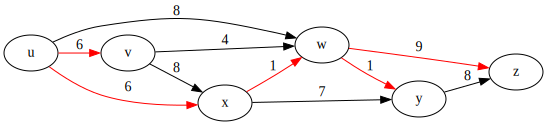

In [8]:
sptree = graphviz.Digraph("Dijkstra's Link State Algorithm", filename='spanning_tree')
sptree.attr(rankdir='LR')

[sptree.node(v) for v in V]
[sptree.edge(u, v, label=str(E[(u, v)]), color="Red" if (u, v) in path else None) for (u, v) in E]

sptree